## 참조자료

https://www.guru99.com/keras-tutorial.html

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [6]:
%matplotlib inline

In [4]:
train_path = './dataset/images/train/'
test_path = './dataaset/images/test/'

In [5]:

batch_size = 16
image_size = 224
num_class = 8


train_datagen = ImageDataGenerator(validation_split=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

Found 6899 images belonging to 8 classes.


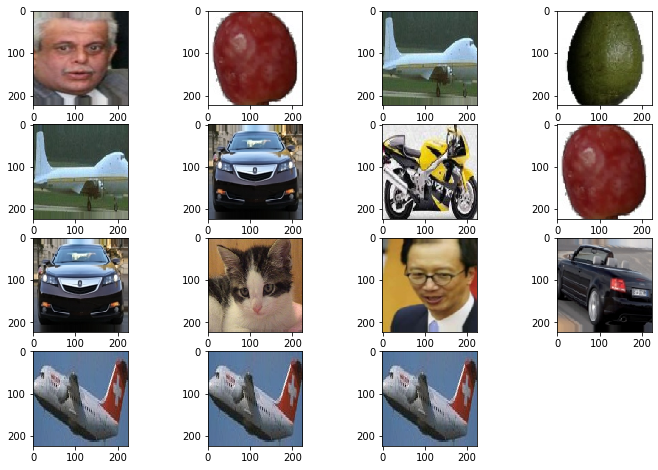

In [11]:
x_batch, y_batch = train_generator.next()

fig=plt.figure(figsize=(12,8))

columns = 4
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [12]:
import keras
from keras.models import Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


#Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

print(base_model.summary())

    # Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False
 
# # Create the model
model = keras.models.Sequential()

# # Add the vgg convolutional base model
model.add(base_model)
 
# # Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_class, activation='softmax'))
 
# # Show a summary of the model. Check the number of trainable parameters    
print(model.summary())

58892288/58889256 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________________

In [ ]:
# # Compile the model
from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
          optimizer=SGD(lr=1e-3),
          metrics=['accuracy'])

# # Start the training process
# model.fit(x_train, y_train, validation_split=0.30, batch_size=32, epochs=50, verbose=2)

# # #save the model
# model.save('catdog.h5')

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n/batch_size,
        epochs=10)
        
model.save('fine_tune.h5')

# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

Epoch 1/10
432/431 [==============================] - 463s 1s/step - loss: 0.5080 - accuracy: 0.9581
Epoch 2/10
252/431 [================>.............] - ETA: 3:14 - loss: 0.1074 - accuracy: 0.9854

In [ ]:
model = load_model('fine_tune.h5')

test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

test_generator = test_datagen.flow_from_directory(
                        directory=test_path, 
                        target_size=(image_size, image_size),
                        color_mode='rgb',
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

fig=plt.figure()
columns = 4
rows = 4
for i in range(1, columns*rows -1):
    x_batch, y_batch = test_generator.next()

    name = model.predict(x_batch)
    name = np.argmax(name, axis=-1)
    true_name = y_batch
    true_name = np.argmax(true_name, axis=-1)

    label_map = (test_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in name]
    true_value = [label_map[k] for k in true_name]

    image = x_batch[0].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.title(str(predictions[0]) + ':' + str(true_value[0]))
    plt.imshow(image)
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16
from keras_vggface.vggface import VGGFace

face_model = VGGFace(model='vgg16', 
                weights='vggface',
                input_shape=(224,224,3)) 
face_model.summary()

In [ ]:
for layer in face_model.layers:
    layer.trainable = False

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

person_count = 5

last_layer = face_model.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dense(1024, activation='relu', name='fc6')(x)
x = Dense(1024, activation='relu', name='fc7')(x)
out = Dense(person_count, activation='softmax', name='fc8')(x)

custom_face = Model(face_model.input, out)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 5
train_path = 'data/'
eval_path = 'eval/'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                        train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='sparse',
                        color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(
    directory=eval_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
)

In [ ]:
from keras.optimizers import SGD

custom_face.compile(loss='sparse_categorical_crossentropy',
                         optimizer=SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

history = custom_face.fit_generator(
        train_generator,
        validation_data=valid_generator,
        steps_per_epoch=49/batch_size,
        validation_steps=valid_generator.n,
        epochs=50)

custom_face.evaluate_generator(generator=valid_generator)
        
custom_face.save('vgg_face.h5')

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras_vggface.utils import preprocess_input

test_img = image.load_img('test.jpg', target_size=(224, 224))
img_test = image.img_to_array(test_img)
img_test = np.expand_dims(img_test, axis=0)
img_test = utils.preprocess_input(img_test)
predictions = model.predict(img_test)
predicted_class=np.argmax(predictions,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class]
print(predictions)
['RobertDJr']

In [ ]:
#Load trained model
from keras.models import load_model
from keras_vggface import utils
import cv2

image_size = 224
device_id = 0 #camera_device id 

model = load_model('my faces.h5')

#make labels according to your dataset folder 
labels = dict(fisrtname=0,secondname=1) #and so on
print(labels)

cascade_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
camera = cv2.VideoCapture(device_id)

while camera.isOpened():
    ok, cam_frame = camera.read()
    if not ok:
        break
    
    gray_img=cv2.cvtColor(cam_frame, cv2.COLOR_BGR2GRAY)
    faces= cascade_classifier.detectMultiScale(gray_img, minNeighbors=5)

    for (x,y,w,h) in faces:
        cv2.rectangle(cam_frame,(x,y),(x+w,y+h),(255,255,0),2)
        roi_color = cam_frame [y:y+h, x:x+w]
        roi color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
        roi_color = cv2.resize(roi_color, (image_size, image_size))
        image = roi_color.astype(np.float32, copy=False)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image, version=1) # or version=2
        preds = model.predict(image)
        predicted_class=np.argmax(preds,axis=1)

        labels = dict((v,k) for k,v in labels.items())
        name = [labels[k] for k in predicted_class]

        cv2.putText(cam_frame,str(name), 
                    (x + 10, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 2)
        
    cv2.imshow('video image', cam_frame)
    key = cv2.waitKey(30)
    if key == 27: # press 'ESC' to quit
        break

camera.release()
cv2.destroyAllWindows()